# Coveo Data Analysis Challenge
### Andrew Sutcliffe - Mai 2019

This document was produced as an answer to the 4 following questions:

1. There was a bug in the code and for one specific country, the records don't have the country field logged. It just shows up as an empty field (""). The search sessions with a missing country either come from a country that is completely missing from the data, or from one of the countries that are logged in the data. Can you determine which country it is the most likely to be? Explain your hypothesis and the data analysis tasks you did to find the missing country.
2. Given a sequence of searched cities, find the most likely city or cities to be also searched next, within the same session. Your code should include a function that takes a list of 0 to ​n​ cities and returns the most likely next city or cities. Keep in mind that the goal is to call this function each time a user performs a search. It should therefore be fast to execute.
3. There are few features describing each user: user id, joining date and country. Are these features useful to predict the most likely city to be searched? How do they compare to the other features tried in Question 2 (i.e. previous cities searched)? Can the algorithm implemented in Question 2 be improved by making use of these features?
4. How did you measure the performance of the prediction algorithms from questions 2 and 3? What is your confidence that the measured score is accurate?


This document is separated in 3 sections. Section 1, **Preliminary Data Analysis**, which answers questions 1 and 4. 
Section 2, **A Simple Predictor**, which answers question 2. And Section 3, **Trying Improve the Priors** which answers question 3. Function calls are included in the code to generate and plot data, train models and evaluate results. The underlying implementations are hidden away in the accompanying code files. This was done to simplify the reading of the document. The results and analysis shown in this document serves to illustrate interesting properties of the data and models used. Some code may not be called in the notebook but all code should be adequately documented in order to facilitate its understanding. 

#### Technical details 
The code is written in Python. The libraries below and any dependencies are required to run this playbook in its entirety. Please run the imports and ensure all imports are done successfully before continuing further with the playbook. 

In [1]:
import json
import warnings
from importlib import reload
import pandas as pd
import numpy as np
import datetime
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.manifold import LocallyLinearEmbedding
from IPython.display import HTML, Latex
import matplotlib.pyplot as plt
import helpers
import SessionSet
from BayesianModel import BayesianModel
import model_evaluation
from model_evaluation import compute_generalization_error_estimate

## 1. Preliminary Data Analysis

### 1.1 Assumptions
I assumed that the data is well formed and representative of real queries made by users. I did not look for corruption in the timestamps or the user ids as the analysis did not suggest any such problems. Neither did I look extensively for hand engineered patterns in the data. Finally I did not take into consideration the one field which was not specified in the problem document: `user._row`. Section 3 discusses potential analyses which could haven been performed with this field. The data was cleaned to match a JSON format which was compatible with Pandas. 

###  1.2 Loading the data

The data is loaded from the provided JSON. User information is flattened and city lists are transformed into Python lists. Many extra fields were computed from the time stamps in order to facilitate the analysis of the data. These fields will be explained when they are used in the modeling or analysis. The code below loads the data and outputs the top 5 rows of the pandas dataframe. 

In [2]:
with open('./city_search.json') as data:
    json_data = json.load(data)
helpers.preprocess_json_for_pandas(json_data)
df = pd.io.json.json_normalize(json_data)
df['time_of_day'] = pd.Series(df['unix_timestamp'] % helpers.SECONDS_PER_DAY)
df['hour_of_day'] = pd.Series(df['time_of_day'] // helpers.SECONDS_PER_HOUR)
df['centered_hour'] = df.apply(helpers.to_normalized_time, axis=1)
df['session_date'] = df.apply(lambda row: datetime.datetime.utcfromtimestamp(row['unix_timestamp']), axis=1)
df['month'] = df.apply(lambda row: row['session_date'].month, axis=1)
df['day'] = df.apply(lambda row: row['session_date'].day, axis=1)
df['year'] = df.apply(lambda row: row['session_date'].year, axis=1)
df['join_month'] = df.apply(lambda row: row['user.joining_date'].split('-')[1], axis=1)
df['join_day'] = df.apply(lambda row: row['user.joining_date'].split('-')[2], axis=1)
df['request_count'] = df.apply(lambda row: len(row['cities']), axis=1)
df.replace('','??', inplace=True)
df['country_index'] = df.apply(lambda row: helpers.get_index_for_country(row['user.country']), axis=1) 
df.head()

,cities,session_id,unix_timestamp,user._row,user.country,user.joining_date,user.user_id,time_of_day,hour_of_day,centered_hour,session_date,month,day,year,join_month,join_day,request_count,country_index
0,"[new york ny, newark nj]",X061RFWB06K9V,1442503708,NaN,UK,2015-03-22,2024,55708,15,3,2015-09-17 15:28:28,9,17,2015,03,22,2,0
1,"[new york ny, jersey city nj, philadelphia pa]",5AZ2X2A9BHH5U,1441353991,NaN,DE,2015-03-28,2853,29191,8,-3,2015-09-04 08:06:31,9,4,2015,03,28,3,3
2,[san antonio tx],SHTB4IYAX4PX6,1440843490,NaN,UK,2015-03-06,10958,37090,10,-2,2015-08-29 10:18:10,8,29,2015,03,06,1,0
3,[edmonton ab],JBRB8MZGTX3M4,1427268063,NaN,IT,2015-03-12,7693,26463,7,-4,2015-03-25 07:21:03,3,25,2015,03,12,1,2
4,"[phoenix az, houston tx]",YJCMPURC2FL9C,1430559067,NaN,UK,2015-02-28,7506,34267,9,-3,2015-05-02 09:31:07,5,2,2015,02,28,2,0


In order to facilitate the analysis the data is separated by `user.country` and loaded into a custom class (found in SessionSet.py). These instances are organized into a dictionary with their country tags as keys. I also computed time metrics, which are statistics on the time of requests based on the different countries. These are stored a dataframe. 

In [3]:
countries_sessions = {} 
time_summary_df = pd.DataFrame()
for country in set(df['user.country'].values):
    countries_sessions[country] = SessionSet.SessionSet(df.loc[df.loc[:,'user.country'] == country ,:], country)
    time_summary_df[country] = countries_sessions[country].get_time_metrics()
countries_sessions['ALL'] = SessionSet.SessionSet(df,'ALL')
time_summary_df['ALL'] = countries_sessions['ALL'].get_time_metrics()
time_summary_df = time_summary_df.T

### 1.3 Answering Question 1: What is the missing label?

In order to answer Question 1 I will look at the distribution of sessions across countries by time and by user id. 

#### 1.3.1 Time of Request Analysis

I grouped the sessions by country. The means and medians of the times by country seem to fall in line with the timezones of each country, assuming that users, irregardless of country, have similar patterns when they search for destinations. The following table illustrates this result. The times are presented in hours in the day with respect to UTC. This was computed by applying the modulo operation on the unix timestamp to get the time of day (using $60*60*24=86400$ seconds in a day) and then using integer division with the number of seconds in an hour ($3600$). 

In [33]:
time_summary_df

,count,mean,std,min,25%,50%,75%,max
ES,1953.0,10.837686,3.183071,3.0,8.0,11.0,13.0,21.0
US,3876.0,16.784830,5.731015,0.0,15.0,18.0,21.0,23.0
UK,3555.0,11.959212,3.215444,3.0,9.0,12.0,14.0,22.0
??,2820.0,6.580142,3.123955,0.0,4.0,7.0,9.0,16.0
IT,1882.0,11.007970,3.281809,2.0,8.0,11.0,14.0,19.0
FR,2298.0,11.037424,3.183051,2.0,9.0,11.0,14.0,20.0
DE,3638.0,10.987356,3.211002,2.0,8.0,11.0,13.0,20.0
ALL,20022.0,11.654580,4.854823,0.0,8.0,11.0,15.0,23.0


This give an indication that the unknown label is potentially drawn from users in a timezone which is approximately UTC+6 (i.e. India is UTC+5:30). In order to add weight to this hypothesis, I checked two things:
 1. the assumption by which users from different countries have similar behaviours
 2. if there was an overlap in users per country (1.3.2)

Below is a plot of the histograms of user session times centered about their medians. In other words, the median of the data is set as the zero and the data is binned by hour in accordance to its distance to the median. European users have very nice bell curved shape to their usage. The American plot is a bit flatter, but this may be due to the fact that the USA span more than one timezone. Finally, the histogram for the unknown country label ("??") looks similar to the others. 

These results support the hypothesis that the unknown country is in or around UTC+6:00 by illustrating the similarity in the distribution of session times. The dips in the histogram may indicate meal times in different countries. 

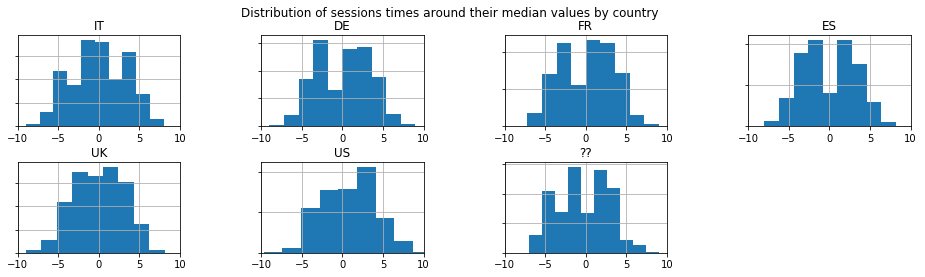

In [34]:
fig, axes = plt.subplots(2, 4, figsize=(16,4))
#IT
(countries_sessions['IT'].df['centered_hour']).hist(ax=axes[0,0])
axes[0,0].set_title('IT')
axes[0,0].set_xlim(-10,10)
axes[0,0].set_yticklabels([])
#DE
(countries_sessions['DE'].df['centered_hour']).hist(ax=axes[0,1])
axes[0,1].set_title('DE')
axes[0,1].set_xlim(-10,10)
axes[0,1].set_yticklabels([])
#FR
(countries_sessions['FR'].df['centered_hour']).hist(ax=axes[0,2])
axes[0,2].set_title('FR')
axes[0,2].set_xlim(-10,10)
axes[0,2].set_yticklabels([])
#ES
(countries_sessions['ES'].df['centered_hour']).hist(ax=axes[0,3])
axes[0,3].set_title('ES')
axes[0,3].set_xlim(-10,10)
axes[0,3].set_yticklabels([])
#UK
(countries_sessions['UK'].df['centered_hour']).hist(ax=axes[1,0])
axes[1,0].set_title('UK')
axes[1,0].set_xlim(-10,10)
axes[1,0].set_yticklabels([])
#US
(countries_sessions['US'].df['centered_hour']).hist(ax=axes[1,1])
axes[1,1].set_title('US')
axes[1,1].set_xlim(-10,10)
axes[1,1].set_yticklabels([])
#??
(countries_sessions['??'].df['centered_hour']).hist(ax=axes[1,2])
axes[1,2].set_title('??')
axes[1,2].set_xlim(-10,10)
axes[1,2].set_yticklabels([])

axes[1,3].axis('off')
fig.suptitle('Distribution of sessions times around their median values by country')
plt.subplots_adjust(wspace=0.5, hspace=0.4)

#### 1.3.2 User Analysis

One observation that would invalidate the previous analysis would be if there were users that belonged to both the unknown country and one of the known countries. As the graph below shows, this is not the case since all user IDs are found only in one country. This is show by the fact that the only non-zero values are on the diagonal and the set of overlaps between two countries has a cardinality of 0. 

In [35]:
helpers.compute_user_origin_matrix(countries_sessions)

,ES,US,UK,??,IT,FR,DE,ALL
ES,569.0,0.0,0.0,0.0,0.0,0.0,0.0,569.0
US,0.0,1129.0,0.0,0.0,0.0,0.0,0.0,1129.0
UK,0.0,0.0,1043.0,0.0,0.0,0.0,0.0,1043.0
??,0.0,0.0,0.0,792.0,0.0,0.0,0.0,792.0
IT,0.0,0.0,0.0,0.0,528.0,0.0,0.0,528.0
FR,0.0,0.0,0.0,0.0,0.0,665.0,0.0,665.0
DE,0.0,0.0,0.0,0.0,0.0,0.0,1051.0,1051.0
ALL,569.0,1129.0,1043.0,792.0,528.0,665.0,1051.0,5777.0


I also looked at when the users joined and noticed they all joined at around the same time: March. 

In [36]:
countries_sessions['ALL'].df['join_month'].value_counts()

03    18268
04     1077
02      677
Name: join_month, dtype: int64

#### 1.3.3 Cities Analysis

I looked at the number of cities per session and the number of cities per user. Roughly half the sessions had only one city, this will be a strong limiting factor for question 2. 

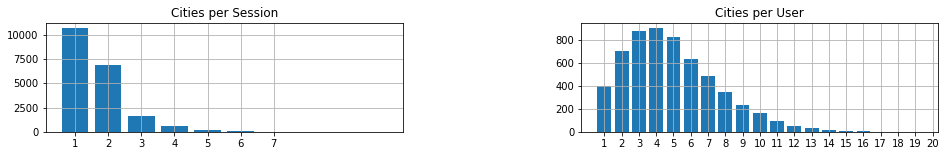

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,2))
(countries_sessions['ALL'].get_requests_stats()).hist(ax=ax1,rwidth=0.8)
ax1.set_title('Cities per Session')
ax1.set_xticks([1.5,2.5,3.5,4.5,5.5,6.5,7.5])
ax1.set_xticklabels([1,2,3,4,5,6,7])
(countries_sessions['ALL'].get_requests_stats_per_user()).hist(ax=ax2, rwidth=0.8, bins=19)
ax2.set_title('Cities per User')
ax2.set_xticks([1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5,16.5,17.5,18.5,19.5,20.5])
ax2.set_xticklabels([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
plt.subplots_adjust(wspace=0.5, hspace=0.4)

Users made requests over multiple sessions.

In [38]:
session_count_df = pd.DataFrame(df['user.user_id'].value_counts().value_counts().sort_index())
session_count_df.rename(columns={'user.user_id':'user count'}, inplace=True)
session_count_df.index.name = '# sessions'

cities_count_df = pd.DataFrame((countries_sessions['ALL'].get_requests_stats_per_user())['cities_per_user'].value_counts().sort_index())
cities_count_df.rename(columns={'cities_per_user':'user count'}, inplace=True)
cities_count_df.index.name = '# cities'

session_city_count_df = pd.DataFrame(countries_sessions['ALL'].get_requests_stats().value_counts())
session_city_count_df.rename(columns={0:'session count'}, inplace=True)
session_city_count_df.index.name = '# cities'

helpers.display_side_by_side(session_count_df, cities_count_df, session_city_count_df)


,user count
# sessions,
1,693
2,1209
3,1307
4,1095
5,736
6,404
7,213
8,77
9,36


Finally, I observed that the distribution of the top cities requested in sessions is fairly stable across many segmentations of the data. I chose only to show the distribution of the top cities for the main dataset and per country segment. Segmentations which were tried: by country, after collapsing users, by month on in the year, by hour in the day and by join date.

In [39]:
n_top = 10
top_5_all = pd.DataFrame(countries_sessions['ALL'].get_top_cities_with_precentage(n_top))
top_5_all.index.name = 'ALL'
top_5_fr = pd.DataFrame(countries_sessions['FR'].get_top_cities_with_precentage(n_top))
top_5_fr.index.name = 'FR'
top_5_it = pd.DataFrame(countries_sessions['IT'].get_top_cities_with_precentage(n_top))
top_5_it.index.name = 'IT'
top_5_de = pd.DataFrame(countries_sessions['DE'].get_top_cities_with_precentage(n_top))
top_5_de.index.name = 'DE'
top_5_es = pd.DataFrame(countries_sessions['ES'].get_top_cities_with_precentage(n_top))
top_5_es.index.name = 'ES'
top_5_uk = pd.DataFrame(countries_sessions['UK'].get_top_cities_with_precentage(n_top))
top_5_uk.index.name = 'UK'
top_5_us = pd.DataFrame(countries_sessions['US'].get_top_cities_with_precentage(n_top))
top_5_us.index.name = 'US'
top_5_qq = pd.DataFrame(countries_sessions['??'].get_top_cities_with_precentage(n_top))
top_5_qq.index.name = '??'
helpers.display_side_by_side(top_5_all,top_5_fr,top_5_it,top_5_de,top_5_es,top_5_uk,top_5_us,top_5_qq)


,0,1
ALL,,
0,new york ny,0.267755
1,toronto on,0.163770
2,los angeles ca,0.133453
3,montreal qc,0.116672
4,chicago il,0.098841
5,houston tx,0.069623
6,vancouver bc,0.068724
7,philadelphia pa,0.052742
8,san antonio tx,0.037409


#### 1.3.4 Answer to Question 1

Given the results of 1.3.1 and 1.3.2 I would say there is a good chance the missing label is India or a neighbouring country. 

### 1.4 Answer to Question 4: Evaluating models 
  

Models are evaluated by using 3 fold cross-validation repeated 5 times. This generates mean estimates for the train and test errors as well as standard deviation values for these estimates. I use stratified splits based on the country of origin to try to limit the introduction of dataset artifacts as much as possible. I try to keep the original distribution of the data in my train and test splits. The stratification is based on the assumption outlined above that the dataset is representative of the true underlying distribution of data.

For test queries I take a query from the test set and randomly removed one city from the sequence. The removed city becomes the target and the shortened query becomes the test case. This allows me to produce test cases of different lengths which are relevant to the problem. The cities are remove randomly since most of the sessions only have one or 2 cities and therefore considering chronological sequences would have at best a limited impact on the over all score. 

I present results in the form of a table, showing how the results evolve over two dimensions.

The first dimension is the length of the query string. I look at a partition of test lengths of 0,1,2 and 3+ cities for this analysis since any further segmentation would yield sets which are too small.  A test length of n corresponds to an original session length of n+1. ALL corresponds to the accuracy on the full test set irregardless of query length.

The second dimension is the occurrence of the target in the top n proposed cities. The ideal model might always propose the right city. That being said I find it reasonable to look at the top 3 and top 5 predictions to establish if model is performing well. 

The standard deviations (STD) and training accuracy are reported for the simple model. There is no sign of over fitting and the STD is low. This gives me confidence that the test error computed is close to the true error. 


## 2 A Simple Predictor

I use a Bayesian approach to compute the maximum likelihood of observing a city based on a request of size 0 to n.
Bayes theorem states that:

\begin{align}
P(A|B) = \frac{P(B|A)P(A)}{P(B)}
\end{align}


I also make the strong assumption of independence between pairs of cities, which lets me rewrite the above equation in the context of our problem. Given a list of cities $C_1, ..., C_n$ I can compute the probability of $C_q$ being the next city queried by the following equation:

\begin{align}
P(C_q|C_1,...,C_n) = \prod_{i=1}^{n}{\frac{P(C_q|C_i)P(C_i)}{P(C_q)}}
\end{align}

I can then order the cities by how likely they are of being the next city picked and return this ordered list of cities as a results. Since I am only interested in a comparison I can drop the denominator $P(C_q)$ and use the log for computations which has the double benefit of reducing numerical errors and mapping products to sums. This allows me to have a model that is quick to evaluate as it simply does vector addition on vectors of length equal to the number of cities observed.

Below, I show train and test results for 5 repetitions of 3 fold cross-validation. I decided to split the data set in a stratified manner keeping the same distribution of `user.country` in each dataset. Even though the preliminary analysis did not show any significant difference between the distributions of requested cities per country, I thought it more representative to use this stratification.

In [4]:
# the code handles the division by zero warning but it is output to the screen
# to improve the notebook legibility warnings are disabled for this part.
warnings.filterwarnings('ignore')
results = model_evaluation.compute_generalization_error_estimate(
    countries_sessions['ALL'],
    folds=3,
    repeats=5,
    stratification='user.country',
    top_x_cities=5,
    max_request_size_for_stats = 3)
warnings.filterwarnings('once')

Running model evaluation 3 folds x 5 repeats = 15 times...............Done


### Train results

In [5]:
train_df = helpers.format_results(results['mean_train'], results['tracker'], column_info='Accuracy Bayes (train)', index_info='Test Query length')
train_std_df = helpers.format_results(results['std_train'], results['tracker'], column_info='STD (train)', index_info='Test Query length')
helpers.display_side_by_side(train_df, train_std_df)

Accuracy Bayes (train),top 1,top 3,top 5
Test Query length,,,
0,0.213474,0.432764,0.586635
1,0.296911,0.485095,0.639416
2,0.495027,0.835110,0.942120
3+,0.553208,0.907008,0.979449
ALL,0.279036,0.502913,0.649790
STD (train),top 1,top 3,top 5
Test Query length,,,
0,0.002180,0.002106,0.003145
1,0.005500,0.009819,0.005818


### Test results

In [6]:
results_df = helpers.format_results(results['mean'], results['tracker'], column_info='Accuracy Bayes', index_info='Test Query length')
std_df = helpers.format_results(results['std'], results['tracker'], column_info='STD', index_info='Test Query length')
helpers.display_side_by_side(results_df, std_df)

Accuracy Bayes,top 1,top 3,top 5
Test Query length,,,
0,0.213469,0.432772,0.586629
1,0.295317,0.482381,0.633095
2,0.484784,0.822386,0.936171
3+,0.537728,0.883884,0.961566
ALL,0.277016,0.499998,0.646388
STD,top 1,top 3,top 5
Test Query length,,,
0,0.004361,0.004202,0.006284
1,0.008446,0.012674,0.011901


I also compared the model to one using only the prior $P(C_i)$ and not the co-occurrence model. 

### Results No Co-Occurrence

I show only the test and train error and not the STDs.

In [7]:
warnings.filterwarnings('ignore')
results_prior_only = model_evaluation.compute_generalization_error_estimate(
    countries_sessions['ALL'],
    folds=3,
    repeats=5,
    stratification='user.country',
    top_x_cities=5,
    max_request_size_for_stats = 3,
    ignore_coocurrences=True)
results_prior_df = helpers.format_results(results_prior_only['mean'], results['tracker'], column_info='Accuracy Prior', index_info='Test Query length')
helpers.display_side_by_side(results_df, results_prior_df)
train_prior_df = helpers.format_results(results_prior_only['mean_train'], results['tracker'], column_info='Accuracy Prior (train)', index_info='Test Query length')
helpers.display_side_by_side(train_df, train_prior_df)
warnings.filterwarnings('once')

Running model evaluation 3 folds x 5 repeats = 15 times...............Done


Accuracy Bayes,top 1,top 3,top 5
Test Query length,,,
0,0.213469,0.432772,0.586629
1,0.295317,0.482381,0.633095
2,0.484784,0.822386,0.936171
3+,0.537728,0.883884,0.961566
ALL,0.277016,0.499998,0.646388
Accuracy Prior,top 1,top 3,top 5
Test Query length,,,
0,0.213484,0.432772,0.586643
1,0.197821,0.410238,0.555422


Accuracy Bayes (train),top 1,top 3,top 5
Test Query length,,,
0,0.213474,0.432764,0.586635
1,0.296911,0.485095,0.639416
2,0.495027,0.835110,0.942120
3+,0.553208,0.907008,0.979449
ALL,0.279036,0.502913,0.649790
Accuracy Prior (train),top 1,top 3,top 5
Test Query length,,,
0,0.213478,0.432764,0.586638
1,0.197553,0.412871,0.557988


These results show that the inclusion of co-occurrence probabilities has an a positive impact on performance of requests of length 2 or more. Query requests of length 1 are negatively impacted by the inclusion of the co-occurrence probability. This may indicate that the prior is not optimal or that it gets overtaken too rapidly by the co-occurrence probability. This will be explored in the next section. 

### Answer to Question 2:

I provide a trained model below with a test query. Feel free to change the query and run the prediction to see what the output. The output will be a list of cities ordered from the most likely to the least likely to be queried, according to the model.

#### Training

In [8]:
start = time.time()
warnings.filterwarnings('ignore')
model = BayesianModel()
possible_cities = countries_sessions['ALL'].get_list_of_cities()
model.fit(possible_cities, countries_sessions['ALL'].df)
end = time.time()
warnings.filterwarnings('once')
print('Train time: {0}'.format(end-start))

Train time: 0.28537988662719727


In [9]:
start = time.time()
prediction = model._predict(['kansas city mo', 'new orleans la'])
end = time.time()
print('Query time: {0}'.format(end-start))
print(prediction[0:5])


Query time: 0.0010533332824707031
['chicago il', 'san antonio tx', 'jacksonville fl', 'new york ny', 'milwaukee wi']


## 3. Trying to Improve the Priors

The dataset provided contains more information regarding users and sessions. I will first study the impact of aggregating sessions, by user id and session times, in order to try and improve the prior. I will then generate a alternative prior by using one-vs-all Logistic Regression classifiers.  

### 3.1 Aggregating the data according to user properties

In a first step, I merge all user sessions together and look at the results. I also look at aggregations of user sessions in a same month, user sessions in a same day, at the same hour of day. This approach does aggregation before fitting the model and therefore has an impact not only on the prior but on the co-occurrence matrix also. 

In [10]:
warnings.filterwarnings('ignore')
results_user = model_evaluation.compute_generalization_error_estimate(
    countries_sessions['ALL'],
    folds=3,
    repeats=5,
    stratification='user.country',
    top_x_cities=5,
    max_request_size_for_stats = 3,
    aggregation=['user.user_id'])
results_user_month = model_evaluation.compute_generalization_error_estimate(
    countries_sessions['ALL'],
    folds=3,
    repeats=5,
    stratification='user.country',
    top_x_cities=5,
    max_request_size_for_stats = 3,
    aggregation=['user.user_id', 'month'])
results_user_day = model_evaluation.compute_generalization_error_estimate(
    countries_sessions['ALL'],
    folds=3,
    repeats=5,
    stratification='user.country',
    top_x_cities=5,
    max_request_size_for_stats = 3,
    aggregation=['user.user_id', 'month','day'])
results_time_country = model_evaluation.compute_generalization_error_estimate(
    countries_sessions['ALL'],
    folds=3,
    repeats=5,
    stratification='user.country',
    top_x_cities=5,
    max_request_size_for_stats = 3,
    aggregation=['user.country', 'month','day','centered_hour'])
results_user_hour = model_evaluation.compute_generalization_error_estimate(
    countries_sessions['ALL'],
    folds=3,
    repeats=5,
    stratification='user.country',
    top_x_cities=5,
    max_request_size_for_stats = 3,
    aggregation=['user.user_id', 'centered_hour'])
results_hour = model_evaluation.compute_generalization_error_estimate(
    countries_sessions['ALL'],
    folds=3,
    repeats=5,
    stratification='user.country',
    top_x_cities=5,
    max_request_size_for_stats = 3,
    aggregation=['centered_hour'])
warnings.filterwarnings(action='once')

Running model evaluation 3 folds x 5 repeats = 15 times...............Done
Running model evaluation 3 folds x 5 repeats = 15 times...............Done
Running model evaluation 3 folds x 5 repeats = 15 times...............Done
Running model evaluation 3 folds x 5 repeats = 15 times...............Done
Running model evaluation 3 folds x 5 repeats = 15 times...............Done
Running model evaluation 3 folds x 5 repeats = 15 times...............Done


In [11]:
results_user_df = helpers.format_results(results_user['mean'], results_user['tracker'], column_info='User Id Accuracy', index_info='Test Query length')
results_user_month_df = helpers.format_results(results_user_month['mean'], results_user_month['tracker'],column_info='User + Month Accuracy', index_info='Test Query length')
results_user_day_df = helpers.format_results(results_user_day['mean'], results_user_day['tracker'],column_info='User + Day Accuracy', index_info='Test Query length')
results_time_country_df = helpers.format_results(results_time_country['mean'], results_time_country['tracker'],column_info='Time + Country Accuracy', index_info='Test Query length')
results_user_hour_df = helpers.format_results(results_user_hour['mean'], results_user_hour['tracker'],column_info='User + Hour Accuracy', index_info='Test Query length')
results_hour_df = helpers.format_results(results_hour['mean'], results_hour['tracker'],column_info='Hour Accuracy', index_info='Test Query length')

#### REFERENCE RESULTS &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; STD

In [12]:
helpers.display_side_by_side(results_df, std_df)

Accuracy Bayes,top 1,top 3,top 5
Test Query length,,,
0,0.213469,0.432772,0.586629
1,0.295317,0.482381,0.633095
2,0.484784,0.822386,0.936171
3+,0.537728,0.883884,0.961566
ALL,0.277016,0.499998,0.646388
STD,top 1,top 3,top 5
Test Query length,,,
0,0.004361,0.004202,0.006284
1,0.008446,0.012674,0.011901


####  USER &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; USER + MONTH&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;USER + MONTH + DAY

In [13]:
helpers.display_side_by_side(results_user_df,results_user_month_df,results_user_day_df)

User Id Accuracy,top 1,top 3,top 5
Test Query length,,,
0,0.213465,0.432789,0.586645
1,0.310790,0.507482,0.636814
2,0.259280,0.433658,0.641808
3+,0.204117,0.379874,0.576017
ALL,0.250353,0.456439,0.607972
User + Month Accuracy,top 1,top 3,top 5
Test Query length,,,
0,0.213475,0.432748,0.586621
1,0.308564,0.527602,0.664505


####  MONTH +DAY+HOUR+COUNTRY &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; USER + HOUR&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;HOUR

In [14]:
helpers.display_side_by_side(results_time_country_df, results_user_hour_df, results_hour_df)

Time + Country Accuracy,top 1,top 3,top 5
Test Query length,,,
0,0.213481,0.432763,0.586631
1,0.304629,0.514957,0.669795
2,0.348200,0.703691,0.840636
3+,0.390319,0.669984,0.803128
ALL,0.263109,0.492807,0.644787
User + Hour Accuracy,top 1,top 3,top 5
Test Query length,,,
0,0.213460,0.432768,0.586652
1,0.299460,0.509233,0.650326


Aggregation seems to have the expected effect of improving length one query scores but only slightly. Unfortunately, it sometimes greatly reduces the accuracy of longer queries. One problem with the approach is that the segmentation by day or month is crude and may not represent user activity. For example, a user may go on a few trips in a year, doing each time a few sessions over a limited time frame. Determining this optimal time frame may lead to better results. Although, the above results suggest that this would have limited impact on the overall accuracy. Since sessions with a low number of queries represent a large portion of the dataset, it would be more interesting to look at alternative ways to generate the prior.

### 3.2 Using Logistic Regression to Compute Priors

I tried to use Logistic Regression (LR) in a one versus all approach for each city. The idea was to use the probabilities fit by the LR as a prior. These probabilities would have been higher than those of the Bayesian Prior and might have exploited more interesting relationships in the data. By producing probabilities which are higher, the prior might be stronger and therefore help with short request and then vanish for long requests. 

Unfortunately as I show below by training a LR model to classify `new york ny` (the most common city) based on user properties, LR is not able to properly classify the data given the features available. I decided to start with trying to classify for `new york ny` for two reasons. First, being the most common city it had a more even dataset and therefore could be trained with less dataset manipulations (i.e. resampling). Second, being able to identify `new york ny` would then allow me to identify potentially more interesting patterns in the remaining data without `new york ny` overshadowing the data. 

I first tried dimensionality reductions approaches, not because the data was in high dimensions but because I wanted to try and remove redundant features. 

The first thing I did was run PCA on the numerical values to the dataset to see if there was any way to reduce the dimensionality of the data. It turns out that given the available features dimensionality reduction would not be beneficial given the shape of the PCA variance curve shown below. 

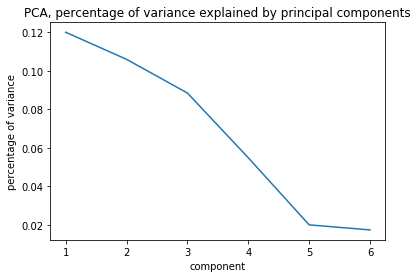

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.3s


{'C': 0.014251026703029992, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
score (all data): 0.42493053559451954
true positives (all data): 2661
true (all data): 5361.0
pred (all data): 9867.0


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.3s finished


In [35]:
columns = ['month','day','join_month','join_day', 'centered_hour', 'country_index']
X = countries_sessions['ALL'].df.loc[:,columns].values.astype(np.float)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
pca = PCA()
pca.fit(X)
plt.plot([1,2,3,4,5,6], pca.explained_variance_)
plt.title('PCA, percentage of variance explained by principal components')
plt.xlabel('component')
plt.ylabel('percentage of variance')
plt.show()

y = countries_sessions['ALL'].df.apply(lambda row: 'new york ny' in row['cities'], axis=1).values.astype(np.float)
ftwo_scorer = make_scorer(fbeta_score, beta=2)
param_grid = [
    {'penalty' : ['l2'],
    'C' : np.logspace(-8, 4, 40),
    'solver' : ['liblinear'],
     'class_weight': ['balanced']
    }
]

clf = GridSearchCV(LogisticRegression(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring=ftwo_scorer)
best_clf = clf.fit(X, y)
print(best_clf.best_params_)
print("score (all data):", best_clf.score(X,y))
print("true positives (all data):",np.sum(np.logical_and(best_clf.predict(X), y)))
print("true (all data):",np.sum(y))
print("pred (all data):", np.sum(best_clf.predict(X)))

The results output above show that the true positive rate is quite low and the Model seems to be fairly arbitrary. I now try to used a Locally Linear Embedding. I thought that this could preserve some of the distance between points in the data set while reducing the dimensionality.

In [36]:
X = countries_sessions['ALL'].df.loc[:,columns].values.astype(np.float)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
lle = LocallyLinearEmbedding(n_components=3)
lle.fit(X)
X = lle.transform(X)
y = countries_sessions['ALL'].df.apply(lambda row: 'new york ny' in row['cities'], axis=1).values.astype(np.float)
ftwo_scorer = make_scorer(fbeta_score, beta=2)
param_grid = [
    {'penalty' : ['l2'],
    'C' : np.logspace(-8, 4, 40),
    'solver' : ['liblinear'],
     'class_weight': ['balanced']
    }
]

clf = GridSearchCV(LogisticRegression(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring=ftwo_scorer)
best_clf = clf.fit(X, y)
print(best_clf.best_params_)
print("score (all data):", best_clf.score(X,y))
print("true positives (all data):",np.sum(np.logical_and(best_clf.predict(X), y)))
print("true (all data):",np.sum(y))
print("pred (all data):", np.sum(best_clf.predict(X)))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'C': 0.05878016072274924, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
score (all data): 0.32063807865847155
true positives (all data): 1805
true (all data): 5361.0
pred (all data): 6703.0


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.5s finished


The score again is very poor. Running without PCA or LLE produces a similar result.

In [37]:
X = countries_sessions['ALL'].df.loc[:,columns].values.astype(np.float)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = countries_sessions['ALL'].df.apply(lambda row: 'new york ny' in row['cities'], axis=1).values.astype(np.float)
ftwo_scorer = make_scorer(fbeta_score, beta=2)
param_grid = [
    {'penalty' : ['l2'],
    'C' : np.logspace(-8, 4, 40),
    'solver' : ['liblinear'],
     'class_weight': ['balanced']
    }
]

clf = GridSearchCV(LogisticRegression(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring=ftwo_scorer)
best_clf = clf.fit(X, y)
print(best_clf.best_params_)
print("score (all data):", best_clf.score(X,y))
print("true positives (all data):",np.sum(np.logical_and(best_clf.predict(X), y)))
print("true (all data):",np.sum(y))
print("pred (all data):", np.sum(best_clf.predict(X)))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'C': 0.014251026703029992, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
score (all data): 0.42493053559451954
true positives (all data): 2661
true (all data): 5361.0
pred (all data): 9867.0


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.4s finished


Since this model is longer to train and is not particularly promising, I trained it for 3 folds and 1 repeat and compared it to the original model in order to confirm the fact that it does not help the overall score. 

In [38]:
warnings.filterwarnings('ignore')
results_LR = model_evaluation.compute_generalization_error_estimate(
    countries_sessions['ALL'],
    folds=3,
    repeats=1,
    stratification='user.country',
    top_x_cities=5,
    max_request_size_for_stats = 3,
    train_lr=True)
warnings.filterwarnings('once')

Running model evaluation 3 folds x 1 repeats = 3 times...Done


Accuracy Bayes,top 1,top 3,top 5
Test Query length,,,
0,0.213483,0.432769,0.586609
1,0.268053,0.441627,0.550492
2,0.350957,0.608732,0.730034
3+,0.379416,0.645938,0.750358
ALL,0.250267,0.458847,0.592504
User Id Accuracy,top 1,top 3,top 5
Test Query length,,,
0,0.000000,0.001875,0.006753
1,0.036658,0.142124,0.242666


#### REFERENCE RESULTS &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; LOGISTIC PRIOR

In [39]:
results_LR_df = helpers.format_results(results_LR['mean'], results_LR['tracker'], column_info='User Id Accuracy', index_info='Test Query length')
helpers.display_side_by_side(results_df, results_LR_df)

Accuracy Bayes,top 1,top 3,top 5
Test Query length,,,
0,0.213483,0.432769,0.586609
1,0.268053,0.441627,0.550492
2,0.350957,0.608732,0.730034
3+,0.379416,0.645938,0.750358
ALL,0.250267,0.458847,0.592504
User Id Accuracy,top 1,top 3,top 5
Test Query length,,,
0,0.000000,0.001875,0.006753
1,0.036658,0.142124,0.242666


Finally, I also ran the model by using previous sessions of a user if this user could be found in the training set. This did not help either.

In [15]:
warnings.filterwarnings('ignore')
results_hist = model_evaluation.compute_generalization_error_estimate(
    countries_sessions['ALL'],
    folds=3,
    repeats=1,
    stratification='user.country',
    top_x_cities=5,
    max_request_size_for_stats = 3,
    check_history=True)
warnings.filterwarnings('once')

Running model evaluation 3 folds x 1 repeats = 3 times...Done


#### REFERENCE RESULTS &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; USER HISTORY

In [41]:
results_hist_df = helpers.format_results(results_hist['mean'], results_hist['tracker'], column_info='User History', index_info='Request length')
helpers.display_side_by_side(results_df, results_hist_df)

Accuracy Bayes,top 1,top 3,top 5
Test Query length,,,
0,0.213483,0.432769,0.586609
1,0.268053,0.441627,0.550492
2,0.350957,0.608732,0.730034
3+,0.379416,0.645938,0.750358
ALL,0.250267,0.458847,0.592504
User History,top 1,top 3,top 5
Request length,,,
0,0.134133,0.272890,0.361862
1,0.170084,0.303467,0.388896


### Answer to Question 3

Both approaches tested, session aggregation and Logistic Regression Prior, were not able to surpass the simple Bayesian model. Using a more user centered approach instead of a content (city) centered approach may yield better results.

## Conclusion

In conclusion, I was able to build a simple model which performed well. The model seems fairly robust and produces the target city in its top three suggestions 45% of the time. 

Unfortunately, I was not able, in the time given, to make any significant improvements to the model. My approach was to use a content based approach mainly to limit the complexity and time and storage of the algorithm. A user based comparison may have proved better, although the preliminary analysis did not highlight any trends in the data. 

Another idea that could have been more successful would have been to concentrate on the rare events and try and model these. Cities like `new york ny` are searched by most and may come and overshadow the data. A city like `madison wi` on the other hand may have had a more typical user or session which could have been identified.